## <center>循环神经网络</center>

### 1 循环神经网络介绍
举个例子,很多课文我们可以顺序背诵,而不能倒序背诵.这种现象可以理解为我们大脑并不是简单的存储,而是链式的,有序的存储.这种存储方式很节省存储空间,对于中间状态的序列,没有直接记住,而是记住了计算方法.
<center><img src='./img/7/1.png' width='600'/></center>

### 2 RNN实现退位减法器

#### (1) 建立基本函数

In [1]:
import numpy as np
import copy
np.random.seed(0)

In [2]:
# 定义 sigmoid 函数
def sigmoid(x):
    output = 1./(1+np.exp(-x))
    return output
# 定义 sigmoid 函数的导数
def sigmoid_derivative(output):
    return output*(1.-output)

#### (2)建立二进制映射

In [3]:
# 构建一个这样的字典:{0:00000000,1:00000001,2:00000010,...,255:11111111}
int2binary = {}
binary_dim = 8
largest_number = np.power(2,binary_dim)
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]

#### (3)定义参数

定义学习参数:隐含层的权重为 synapse_0,循环节点的权重为 synapse_h(输入节点16,输出节点16),输出层的权重为synapse_1(输入16节点,输出1节点).

In [4]:
learning_rate = 0.9 # 学习率
input_dim = 2       # 输入的维度是2,减数和被减数
hidden_dim = 16 
output_dim =1       # 输出维度

# 初始化网络
# 输入维度是2,隐藏维度是16,为了保证初始化参数的范围 [-0.05,0.05]
synapse_0 = (2*np.random.random((input_dim,hidden_dim))-1)*0.05
synapse_1 = (2*np.random.random((hidden_dim,output_dim))-1)*0.05
synapse_h = (2*np.random.random((hidden_dim,hidden_dim))-1)*0.05

# 用于存放反向传播的权重更新值
synapse_0_update = np.zeros_like(synapse_0)
synapse_1_update = np.zeros_like(synapse_1)
synapse_h_update = np.zeros_like(synapse_h)

#### (4) 准备样本数据

大致是这样的过程:
+ 建立循环生成样本数据,先生成两个数 a 和 b .如果 a<b 就交换位置.
+ 计算出相减的结果 c
+ 将三个数转换成二进制.

In [5]:
for j in range(10000):
    a_int = np.random.randint(largest_number)
    b_int = np.random.randint(largest_number/2)
    if a_int < b_int:
        t = b_int
        b_int = a_int
        a_int = t
    # 将三个数都转换为对应的二进制
    a = int2binary[a_int]
    b = int2binary[b_int]
    c = int2binary[a_int-b_int]
    # 模型初始化输出值为0,初始化总误差为0,由于第一个数据传入是传入时,没有前面的隐含层输出值作为本次
    # 样本的输入,所以需要定义一个初始值,这里定义为0.1
    d = np.zeros_like(c)
    overallError = 0
    # 定义 layer_2_deltas 存储反向传播过程中的循环层的误差
    layer_2_deltas = list()
    # layer_1_values 为隐含层的输出值
    layer_1_values = list()
    # 一开始没有隐含层,所以初始化一下原始值为0.1
    layer_1_values.append(np.ones(hidden_dim)*0.1)

#### (5) 正向传播

循环遍历每个二进制位,从个位开始依次相减,并将中间隐藏层的输出传入下一个时间步,把每一个时间步的误差导数记录下来,同时统计总误差.

In [6]:
    for position in range(binary_dim):
        # 生成输入,从右到左,每次取两个输入数字的一个bit位
        x = np.array([[a[binary_dim-position-1],b[binary_dim-position-1]]])
        y = np.array([[c[binary_dim-position-1]]]).T
        # 隐含层的输入,包含上一步的隐藏层和当层的输入,输入层需要经过sigmoid只有才能相加
        # (输入层+之前的隐藏层)->新的隐藏层
        layer_1 = sigmoid(np.dot(x,synapse_0)+np.dot(layer_1_values[-1],synapse_h))
        layer_2 = sigmoid(np.dot(layer_1,synapse_1))
        layer_2_error = y - layer_2
        # 当前时间步误差的导数
        layer_2_deltas.append(layer_2_error*sigmoid_derivative(layer_2))
        overallError += np.abs(layer_2_error[0]) #总误差
        # 记录每次预测的bit位
        d[binary_dim-position-1] = np.round(layer_2[0][0])
        # 将当前的隐藏层保存下来,下个时间序列用
        layer_1_values.append(copy.deepcopy(layer_1))

#### (6) 反向传播

反向传播是从最后一次往前反向计算误差,对于每一个当前的计算都需要下一次结果参与,反向计算从最后一次开始,它没有后一次的输入,所以需要初始化一个值作为其后一次的输入,这里初始化为0

In [7]:
    future_layer_1_delta = np.zeros(hidden_dim)
    # position=[0,1,2,3,4,5,6,7]
    for position in range(binary_dim):
        # 最后一次的两个输入
        x = np.array([[a[position],b[position]]])
        # 当前时间点的隐藏层
        layer_1 = layer_1_values[-position-1]
        # 上一个时间点的隐藏层
        pre_layer_1 = layer_1_values[-position-2]
        # 当前时间点的输出层误差
        layer_2_delta = layer_2_deltas[-position-1]
        # 通过后一个时间点的隐藏层误差和当前时间点的输出层误差,计算当前时间点的隐藏层误差
        layer_1_delta = (np.dot(future_layer_1_delta,synapse_h.T)+
                         np.dot(layer_2_delta,synapse_1.T))*sigmoid_derivative(layer_1)
        # 等完成所有反向传播误差计算,才会更新权重矩阵,先暂时把更新矩阵存起来
        synapse_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
        synapse_h_update += np.atleast_2d(pre_layer_1).T.dot(layer_1_delta)
        synapse_0_update += x.T.dot(layer_1_delta)
        future_layer_1_delta = layer_1_delta

    # 完成所有反向传播之后,更新权重矩阵,并把矩阵变量清零
    synapse_0 += synapse_0_update*learning_rate
    synapse_1 += synapse_1_update*learning_rate
    synapse_h += synapse_h_update*learning_rate
    synapse_0_update *= 0
    synapse_1_update *= 0
    synapse_h_update *= 0

#### (7) 代码汇总

In [8]:
import numpy as np
import copy
np.random.seed(0)

# 定义 sigmoid 函数
def sigmoid(x):
    output = 1./(1+np.exp(-x))
    return output
# 定义 sigmoid 函数的导数
def sigmoid_derivative(output):
    return output*(1.-output)
    
# 构建一个这样的字典:{0:00000000,1:00000001,2:00000010,...,255:11111111}
int2binary = {}
binary_dim = 8
largest_number = np.power(2,binary_dim)
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]
    
learning_rate = 0.9 # 学习率
input_dim = 2       # 输入的维度是2,减数和被减数
hidden_dim = 16 
output_dim =1       # 输出维度

# 初始化网络
# 输入维度是2,隐藏维度是16,为了保证初始化参数的范围 [-0.05,0.05]
synapse_0 = (2*np.random.random((input_dim,hidden_dim))-1)*0.05
synapse_1 = (2*np.random.random((hidden_dim,output_dim))-1)*0.05
synapse_h = (2*np.random.random((hidden_dim,hidden_dim))-1)*0.05

# 用于存放反向传播的权重更新值
synapse_0_update = np.zeros_like(synapse_0)
synapse_1_update = np.zeros_like(synapse_1)
synapse_h_update = np.zeros_like(synapse_h)
    
for j in range(10000):
    a_int = np.random.randint(largest_number)
    b_int = np.random.randint(largest_number/2)
    if a_int < b_int:
        t = b_int
        b_int = a_int
        a_int = t
    # 将三个数都转换为对应的二进制
    a = int2binary[a_int]
    b = int2binary[b_int]
    c = int2binary[a_int-b_int]
    # 模型初始化输出值为0,初始化总误差为0,定义 layer_deltas 存储反向传播过程中的循环层的误差,
    # layer_values 为隐含层的输出值,由于第一个数据传入是传入时,没有前面的隐含层输出值作为本次
    # 样本的输入,所以需要定义一个初始值,这里定义为0.1
    d = np.zeros_like(c)
    overallError = 0
    layer_2_deltas = list()
    layer_1_values = list()
    # 一开始没有隐含层,所以初始化一下原始值为0.1
    layer_1_values.append(np.ones(hidden_dim)*0.1)
    
    for position in range(binary_dim):
        # 生成输入,从右到左,每次取两个输入数字的一个bit位
        x = np.array([[a[binary_dim-position-1],b[binary_dim-position-1]]])
        y = np.array([[c[binary_dim-position-1]]]).T
        # 隐含层的输入,包含上一步的隐藏层和当层的输入,输入层需要经过sigmoid只有才能相加
        # (输入层+之前的隐藏层)->新的隐藏层
        layer_1 = sigmoid(np.dot(x,synapse_0)+np.dot(layer_1_values[-1],synapse_h))
        layer_2 = sigmoid(np.dot(layer_1,synapse_1))
        layer_2_error = y - layer_2
        layer_2_deltas.append(layer_2_error*sigmoid_derivative(layer_2))
        overallError += np.abs(layer_2_error[0]) #总误差
        # 记录每次预测的bit位
        d[binary_dim-position-1] = np.round(layer_2[0][0])
        # 将当前的隐藏层保存下来,下个时间序列用
        layer_1_values.append(copy.deepcopy(layer_1))
    
    future_layer_1_delta = np.zeros(hidden_dim)
    # position=[0,1,2,3,4,5,6,7]
    for position in range(binary_dim):
        # 最后一次的两个输入
        x = np.array([[a[position],b[position]]])
        # 当前时间点的隐藏层
        layer_1 = layer_1_values[-position-1]
        # 上一个时间点的隐藏层
        pre_layer_1 = layer_1_values[-position-2]
        # 当前时间点的输出层误差
        layer_2_delta = layer_2_deltas[-position-1]
        # 通过后一个时间点的隐藏层误差和当前时间点的输出层误差,计算当前时间点的隐藏层误差
        layer_1_delta = (np.dot(future_layer_1_delta,synapse_h.T)+
                         np.dot(layer_2_delta,synapse_1.T))*sigmoid_derivative(layer_1)
        # 等完成所有反向传播误差计算,才会更新权重矩阵,先暂时把更新矩阵存起来
        synapse_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
        synapse_h_update += np.atleast_2d(pre_layer_1).T.dot(layer_1_delta)
        synapse_0_update += x.T.dot(layer_1_delta)
        future_layer_1_delta = layer_1_delta

    # 完成所有反向传播之后,更新权重矩阵,并把矩阵变量清零
    synapse_0 += synapse_0_update*learning_rate
    synapse_1 += synapse_1_update*learning_rate
    synapse_h += synapse_h_update*learning_rate
    synapse_0_update *= 0
    synapse_1_update *= 0
    synapse_h_update *= 0
    
    if j%800 == 0:
        print("error:"+str(overallError))
        print("pred:"+str(d))
        print("true:"+str(c))
        out = 0
        for index,x in enumerate(reversed(d)):
            out += x*pow(2,index)
        print(str(a_int)+" - "+str(b_int)+" = "+str(out))
        print("---------")

error:[3.99972855]
pred:[0 0 0 0 0 0 0 0]
true:[0 0 1 1 0 0 1 1]
60 - 9 = 0
---------
error:[2.486562]
pred:[0 0 0 0 0 0 0 0]
true:[0 0 0 1 0 0 0 1]
17 - 0 = 0
---------
error:[3.51869416]
pred:[0 0 1 0 0 1 1 0]
true:[0 0 0 1 1 1 1 0]
89 - 59 = 38
---------
error:[0.18361106]
pred:[0 0 0 1 1 0 0 0]
true:[0 0 0 1 1 0 0 0]
43 - 19 = 24
---------
error:[0.1709148]
pred:[0 0 0 0 0 0 1 0]
true:[0 0 0 0 0 0 1 0]
73 - 71 = 2
---------
error:[0.13827615]
pred:[0 0 1 1 1 1 0 0]
true:[0 0 1 1 1 1 0 0]
71 - 11 = 60
---------
error:[0.08982648]
pred:[1 0 0 0 0 0 0 0]
true:[1 0 0 0 0 0 0 0]
230 - 102 = 128
---------
error:[0.17024705]
pred:[0 1 1 1 0 0 0 1]
true:[0 1 1 1 0 0 0 1]
160 - 47 = 113
---------
error:[0.06442929]
pred:[0 1 0 1 1 0 0 1]
true:[0 1 0 1 1 0 0 1]
92 - 3 = 89
---------
error:[0.04940924]
pred:[0 0 0 1 1 0 1 1]
true:[0 0 0 1 1 0 1 1]
44 - 17 = 27
---------
error:[0.04009697]
pred:[1 0 0 1 0 1 1 0]
true:[1 0 0 1 0 1 1 0]
167 - 17 = 150
---------
error:[0.06397785]
pred:[1 0 0 1 1

### 3 使用RNN网络拟合回声信号序列

#### (1) 定义参数生成样本数据

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
num_epochs = 5
state_size = 4
num_classes = 2
echo_step = 3
# 每个样本的大小是 15 bit
truncated_backprop_length = 15
# 每个 batch 大小为5
batch_size = 5
# 每个 epoch 有 1000 个batch
num_batches = 1000
total_series_length = num_batches * batch_size * truncated_backprop_length

def generateData():
    # 在0和1中选择 total_series_length 个数
    x = np.array(np.random.choice(2,total_series_length,p=[0.5,0.5]))
    # 向右循环移位
    y = np.roll(x,echo_step)
    # 只有在第一个样本中,前 echo_step 才会用0 填充.
    y[:echo_step]=0
    # 生成 5,10000,将一个长序列截断成 batch_size 个短序列
    x = x.reshape((batch_size,-1))
    y = y.reshape((batch_size,-1))
    return (x,y)

#### (2) 定义占位符处理输入数据

In [11]:
# 输入的数据应该是 (5,15)
input_x = tf.placeholder(dtype=tf.float32,shape=[batch_size,truncated_backprop_length])
input_y = tf.placeholder(dtype=tf.int32,shape=[batch_size,truncated_backprop_length])
# 每个RNN中隐含单元个数,输入的数据应该为(5,4)
init_state = tf.placeholder(dtype=tf.float32,shape=[batch_size,state_size])
# 将 input_x 沿维度为1的轴方向进行拆分,变成了(15,5)
# 在 RNN 网络中,都需要变成(timesteps,batch_size),这样才能在同一个神经元上,
# 处理所有batch中同一个位置的元素,例如这里有 15 个 timesteps,每个timesteps 上的神经元,
# 会处理所有batch中相同位置的数据,这样才能让batch中的数据并行处理.
inputs_series = tf.unstack(input_x,axis=1)
labels_series = tf.unstack(input_y,axis=1)

#### (3) 定义网络结构

In [12]:
current_state = init_state
predictions_series = []
losses = []
# 使用循环,按照序列逐个输入
for current_input,labels in zip(inputs_series,labels_series):
    current_input = tf.reshape(current_input,shape=[batch_size,1])
    # 加入初始状态,拼接之后变成了(5,5)
    input_and_state_concatenated = tf.concat([current_input,current_state],axis=1)
    next_state = tf.contrib.layers.fully_connected(input_and_state_concatenated,state_size,
                                                   activation_fn=tf.tanh)
    # 用于下一个时间步的循环输入
    current_state = next_state
    # 计算当前时间步的输出,由于要使用交叉熵计算,所以这一步没有激活
    logits = tf.contrib.layers.fully_connected(next_state,num_classes,activation_fn=None)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=logits)
    losses.append(loss)
    # 经过激活之后的预测结果
    predictions = tf.nn.softmax(logits)
    predictions_series.append(predictions)
total_loss = tf.reduce_mean(losses)
optimizer = tf.train.AdadeltaOptimizer(learning_rate=0.3).minimize(total_loss)

#### (4) 建立session训练数据

('new data,epoch', 0)
('step', 0, 'loss', 0.71180636)
('step', 100, 'loss', 0.639124)
('step', 200, 'loss', 0.68469185)
('step', 300, 'loss', 0.7073374)
('step', 400, 'loss', 0.6616962)
('step', 500, 'loss', 0.7085965)
('step', 600, 'loss', 0.6887149)
('step', 700, 'loss', 0.62540907)
('step', 800, 'loss', 0.64126164)
('step', 900, 'loss', 0.63603956)
('new data,epoch', 1)
('step', 0, 'loss', 0.646995)
('step', 100, 'loss', 0.6365148)
('step', 200, 'loss', 0.6521179)
('step', 300, 'loss', 0.559955)
('step', 400, 'loss', 0.61287266)
('step', 500, 'loss', 0.6528964)
('step', 600, 'loss', 0.5983753)
('step', 700, 'loss', 0.5994922)
('step', 800, 'loss', 0.58720785)
('step', 900, 'loss', 0.629052)
('new data,epoch', 2)
('step', 0, 'loss', 0.6460512)
('step', 100, 'loss', 0.59902585)
('step', 200, 'loss', 0.5881509)
('step', 300, 'loss', 0.57848835)
('step', 400, 'loss', 0.58026725)
('step', 500, 'loss', 0.56838244)
('step', 600, 'loss', 0.5646521)
('step', 700, 'loss', 0.563715)
('step', 8

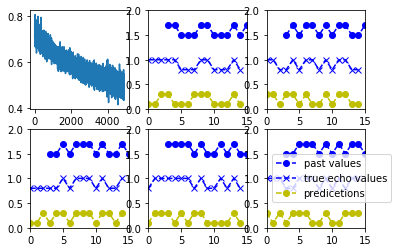

In [13]:
def plot(loss_list,predictions_series,batch_x,batch_y):
    plt.subplot(2,3,1)
    plt.cla()
    plt.plot(loss_list)
    for batch_series_idx in range(batch_size):
        one_hot_output_series = np.array(predictions_series)[:,batch_series_idx,:]
        single_output_series = np.array([(1 if out[0]<0.5 else 0) for out 
                                         in one_hot_output_series])
        plt.subplot(2,3,batch_series_idx+2)
        plt.cla()
        plt.axis([0,truncated_backprop_length,0,2])
        left_offset = range(truncated_backprop_length)
        left_offset2 = range(echo_step,truncated_backprop_length+echo_step)
        label1 = "past values"
        label2 = "true echo values"
        label3 = "predicetions"
        plt.plot(left_offset2,batch_x[batch_series_idx,:]*0.2+1.5,'o--b',label=label1)
        plt.plot(left_offset,batch_y[batch_series_idx,:]*0.2+0.8,'x--b',label=label2)
        plt.plot(left_offset,single_output_series*0.2+0.1,'o--y',label=label3)
    plt.legend(loc='best')
    plt.draw()
    plt.pause(0.0001)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []
    for epoch_idx in range(num_epochs):
        xs,ys = generateData()
        print("new data,epoch",epoch_idx)
        # 初始化第一个隐含状态,这里使用0作为默认初始化
        _current_state = np.zeros((batch_size,state_size),dtype=np.float32)
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            # 每个样本序列长度为15,batch_size 为5,所以 batch_x 的形状为(5,15)
            batch_x = xs[:,start_idx:end_idx]
            batch_y = ys[:,start_idx:end_idx]
            _total_loss,_optimizer,_state,_predictions_series = sess.run([
                total_loss,optimizer,current_state,predictions_series],feed_dict={input_x:batch_x,input_y:batch_y,
                                                                                  init_state:_current_state})
            _current_state = _state
            loss_list.append(_total_loss)
            if batch_idx %100 == 0:
                print("step",batch_idx,"loss",_total_loss)
                plot(loss_list,_predictions_series,batch_x,batch_y)
    plt.ioff()
    plt.show()
            